In [105]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from scipy.sparse import bsr_matrix, coo_matrix
from scipy.sparse.linalg import eigsh
import joblib
from joblib import Parallel, delayed
import itertools
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.datasets import make_swiss_roll
from tqdm import tqdm
import contextlib
import copy
import seaborn as sns

import sys
import os
sys.path.insert(1, os.path.dirname(os.getcwd()))

In [41]:
# support functions
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [42]:
def construct_adjacency_matrix(X, n):
    k = X.shape[0]
    W = np.zeros((k, k))
    neigh = NearestNeighbors(n_neighbors=n+1).fit(X)
    neighbors = neigh.kneighbors(X, n_neighbors=n+1, return_distance=False)[:, 1:]
    for i in range(k):
        W[i, neighbors[i]] = 1
    W = coo_matrix(W)
    W = W + W.transpose()
    W = W.sign()
    return W

def train_and_evaluate(v, s, labels):
    E = v[:s]
    conf = []
    for label in np.unique(labels):
        Y = np.copy(labels)
        Y[labels == label] = 1
        Y[labels != label] = -1
        a = np.linalg.pinv(E) @ Y[:s]
        conf.append(np.sum(v[s:] * a, axis=1).tolist())
    conf = np.array(conf)
    pred_labels = np.argmax(conf, axis=0)
    return np.mean(pred_labels != labels[s:])

def train_and_evaluate_knn(X, s, labels):
    k_vals = [5]
    errors = []
    for k in k_vals:
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(X[:s], labels[:s])
        pred_labels = neigh.predict(X[s:])
        errors.append(np.mean(pred_labels != labels[s:]))
    return min(errors)

In [45]:
X, Y = make_swiss_roll(10000)
idx = np.argsort(Y)
X = X[idx]
Y[:len(Y)//2] = 0
Y[len(Y)//2:] = 1

idx = np.random.permutation(len(Y))
X, Y = X[idx], Y[idx]

In [46]:
# set parameters
n = 5
p = 100
s_list = [50, 100, 500, 1000, 5000]
num_reps = 20

In [47]:
W = construct_adjacency_matrix(X, n)
d = np.array(np.sum(W, axis=1)).squeeze()
D = coo_matrix(W.shape)
D.setdiag(d)
L = D - W

# compute first p eigenvectors with smallest eigenvalues
_ , v = eigsh(L, k=p, which='SM')
v = np.real(v)

In [48]:
# train and evaluate
def loop(X, v0, s, p, labels):
    p = min(s // 5, p) 

    v = v0[:, :p]
    idx = np.random.permutation(len(v))
    error_lssl = train_and_evaluate(v[idx], s, labels[idx])
    error_knn = train_and_evaluate_knn(X, s, labels)

    return [error_lssl, error_knn]

mean_error_list = np.zeros((len(s_list), 2))
std_error_list = np.zeros((len(s_list), 2))
for i, s in enumerate(s_list):
    with tqdm_joblib(tqdm(desc="Run reps", total=num_reps)) as progress_bar:
        buffer = np.array(Parallel(n_jobs=-1)(delayed(loop)(X, v, s, p, Y) for r in range(num_reps)))
    mean_error_list[i] = np.mean(buffer, axis=0)
    std_error_list[i] = np.std(buffer, axis=0)

Run reps: 100%|██████████| 5/5 [00:00<00:00, 17.48it/s]


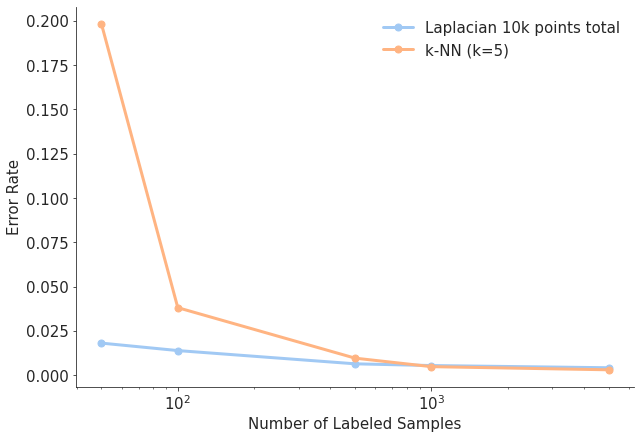

In [50]:
# plot
fig, ax = plt.subplots(figsize=(10, 7))
sns.set_style("white")
sns.set_style("ticks")
sns.set_palette("pastel")
s_list = np.array(s_list)
name_list = ["Laplacian 10k points total",
             "k-NN (k=5)"]
for i in range(mean_error_list.shape[-1]):
    errors = mean_error_list[:, i]
    idx = np.where(errors != -1)[0]
    ax.plot(s_list[idx], errors[idx], lw=3, marker='o', markersize=7, label=name_list[i])
ax.set_xscale('log')
ax.tick_params(labelsize=15)
ax.set_xlabel("Number of Labeled Samples", fontsize=15)
ax.set_ylabel("Error Rate", fontsize=15)
ax.legend(fontsize=15, frameon=False)
sns.despine()
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


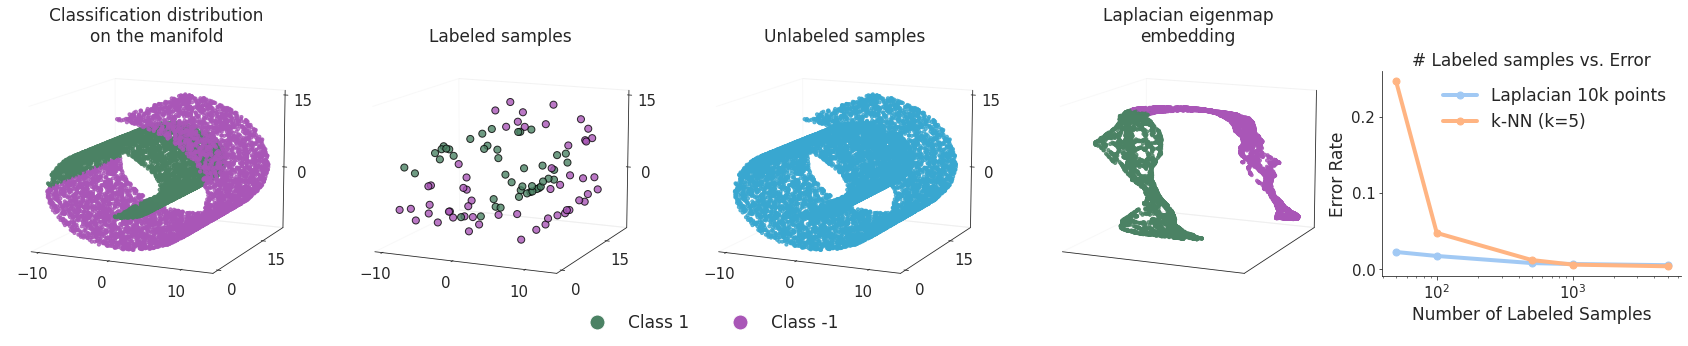

In [198]:
fig = plt.figure(figsize=(30, 6))
fontsize=15

sns.set_palette("pastel")
sns.set_style("white")
sns.set_style("ticks")
cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)

axes = []
ax = fig.add_subplot(1, 5, 1, projection='3d')
ax.scatter(
    X[:, 0], X[:, 1], X[:, 2], c=Y, s=10, alpha=0.8, cmap=cmap
)
ax.view_init(azim=-66, elev=12)
ax.set_title("Classification distribution" + "\n" + "on the manifold", y=1.001, fontsize=fontsize+2)
axes.append(ax)

ax = fig.add_subplot(1, 5, 2, projection='3d')
ax.scatter(
    X[:100, 0], X[:100, 1], X[:100, 2], c=Y[:100], s=50, alpha=0.8, cmap=cmap, edgecolors='k'
)
ax.set_xlim(axes[0].get_xlim())
ax.set_ylim(axes[0].get_ylim())
ax.set_zlim(axes[0].get_zlim())
ax.view_init(azim=-66, elev=12)
ax.set_title("Labeled samples", y=1.001, fontsize=fontsize+2)
axes.append(ax)

ax = fig.add_subplot(1, 5, 3, projection='3d')
ax.scatter(
    X[:, 0], X[:, 1], X[:, 2], c=sns.color_palette("husl", 8)[5], s=10, alpha=0.8
)
ax.view_init(azim=-66, elev=12)
ax.set_title("Unlabeled samples", y=1.001, fontsize=fontsize+2)
axes.append(ax)

ax = fig.add_subplot(1, 5, 4, projection='3d')
ax.scatter(
    v[:, 0], v[:, 1], v[:, 2], c=Y, s=10, alpha=0.8, cmap=cmap
)
ax.set_title("Laplacian eigenmap" + "\n" + "embedding", y=1.001, fontsize=fontsize+2)
ax.view_init(azim=-66, elev=12)
axes.append(ax)

for ax in axes:
    ax.grid(False)
    ax.w_xaxis.pane.fill = False
    ax.w_yaxis.pane.fill = False
    ax.w_zaxis.pane.fill = False
    ax.xaxis.set_major_locator(MaxNLocator(2))
    ax.yaxis.set_major_locator(MaxNLocator(2))
    ax.zaxis.set_major_locator(MaxNLocator(2))
    ax.tick_params(labelsize=15)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax = fig.add_subplot(1, 5, 5)
s_list = np.array(s_list)
name_list = ["Laplacian 10k points",
             "k-NN (k=5)"]
for i in range(mean_error_list.shape[-1]):
    errors = mean_error_list[:, i]
    idx = np.where(errors != -1)[0]
    ax.plot(s_list[idx], errors[idx], lw=4, marker='o', markersize=7, label=name_list[i])
ax.set_xscale('log')
ax.tick_params(labelsize=15)
ax.set_xlabel("Number of Labeled Samples", fontsize=fontsize+2)
ax.set_ylabel("Error Rate", fontsize=fontsize+2)
ax.set_title("# Labeled samples vs. Error", fontsize=fontsize+2)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_locator(MaxNLocator(3))
ax.legend(fontsize=fontsize+2, frameon=False)
ax.set_aspect(7)
sns.despine()

plt.subplots_adjust(wspace=0.15)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Class 1',
                          markerfacecolor=sns.diverging_palette(145, 300, s=60)[0], markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Class -1',
                          markerfacecolor=sns.diverging_palette(145, 300, s=60)[-1], markersize=15)]
plt.figlegend(handles=legend_elements, loc=8, bbox_to_anchor=(0.45, 0.1), fontsize=fontsize+2, frameon=False, ncol=2)
plt.show()

In [199]:
fig.savefig("figures/2-simulation.pdf", bbox_inches='tight')